这里对于边境摩擦的计算，有两种方法：直接利用dist cepii数据集，dummy的方法计算
1 将所有变量都纳入模型中
2 将变量整合成一个变量（border）再纳入模型


In [3]:
import pandas as pd

# 查看所有 sheet 名
xls = pd.ExcelFile(r'../data/raw/dist_cepii/dist_cepii.xls')
print("所有sheet名：", xls.sheet_names)

# 读取主 sheet（通常是第一个）
df = pd.read_excel(xls, sheet_name=xls.sheet_names[0])

# 显示所有列名
print("列名：", df.columns.tolist())


所有sheet名： ['dist_cepii']
列名： ['iso_o', 'iso_d', 'contig', 'comlang_off', 'comlang_ethno', 'colony', 'comcol', 'curcol', 'col45', 'smctry', 'dist', 'distcap', 'distw', 'distwces']
列名： ['iso_o', 'iso_d', 'contig', 'comlang_off', 'comlang_ethno', 'colony', 'comcol', 'curcol', 'col45', 'smctry', 'dist', 'distcap', 'distw', 'distwces']


In [10]:
# 筛选我们需要的列
df_border = df[['iso_o', 'iso_d', 'contig', 'comlang_off', 'colony']].copy()

df_border['border_friction'] = 1 - (
    0.4 * df_border['contig'] +
    0.3 * df_border['comlang_off'] +
    0.3 * df_border['colony']
)

这里先尝试用PCA，

In [16]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 示例：加载你自己的 DataFrame
# df = pd.read_csv("your_cepii_subset.csv")

# 确保变量存在
variables = ['contig', 'comlang_off', 'colony']
assert all(v in df.columns for v in variables), "缺少必要列"

# 1. 标准化变量（Z-score）
X = df[variables]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = StandardScaler().fit_transform(X)


# 2. PCA主成分分析（只保留第一个主成分）
pca = PCA(n_components=1)
pc = pca.fit_transform(X_scaled)

# 3. 添加到原始 DataFrame
df['openness_score'] = pc

# 4. 归一化（0~1之间）
df['openness_score'] = (df['openness_score'] - df['openness_score'].min()) / (
    df['openness_score'].max() - df['openness_score'].min()
)

# 5. 构造边境摩擦变量（反向）
df['border_friction'] = 1 - df['openness_score']

# ✅ 现在你可以使用 df["border_friction"] 作为回归的解释变量了

# 查看主成分载荷（权重）
print("PCA主成分权重（载荷）：")
for var, coef in zip(['contig', 'comlang_off', 'colony'], pca.components_[0]):
    print(f"{var}: {coef:.4f}")


PCA主成分权重（载荷）：
contig: 0.5279
comlang_off: 0.5953
colony: 0.6058


In [34]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_scaled)
print(pca.explained_variance_ratio_)


[0.39590488 0.30927251 0.29482261]


结果显示第一主成分解释的方差只有不到40%，不太合适，所以使用等权重法

In [36]:
import pandas as pd

# 假设df已包含contig, comlang_off, colony三列
df_border = df[['iso_o', 'iso_d', 'contig', 'comlang_off', 'colony']].copy()

# 等权重法：每项权重1/3
df_border['border_friction'] = 1 - (
    (df_border['contig'] + df_border['comlang_off'] + df_border['colony']) / 3
)

# 可选：保存结果
df_border.to_csv('../data/processed/border_friction_panel_ew.csv', index=False)
print("已保存边境摩擦面板 border_friction_panel_ew.csv")

已保存边境摩擦面板 border_friction_panel_ew.csv


count    50176.000000
mean         0.934577
std          0.142448
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: border_friction, dtype: float64
缺失值数量： 0
最小值对应的国家对：
      iso_o iso_d  contig  comlang_off  colony  border_friction
13165   EGY   SDN       1            1       1              0.0
13561   ESH   MAR       1            1       1              0.0
14523   FIN   SWE       1            1       1              0.0
15997   GBR   IRL       1            1       1              0.0
20903   IRL   GBR       1            1       1              0.0
23018   KAZ   RUS       1            1       1              0.0
27164   MAR   ESH       1            1       1              0.0
31580   NAM   ZAF       1            1       1              0.0
38182   RUS   KAZ       1            1       1              0.0
38810   SDN   EGY       1            1       1              0.0
41952   SWE   FIN       1            1       1              0.

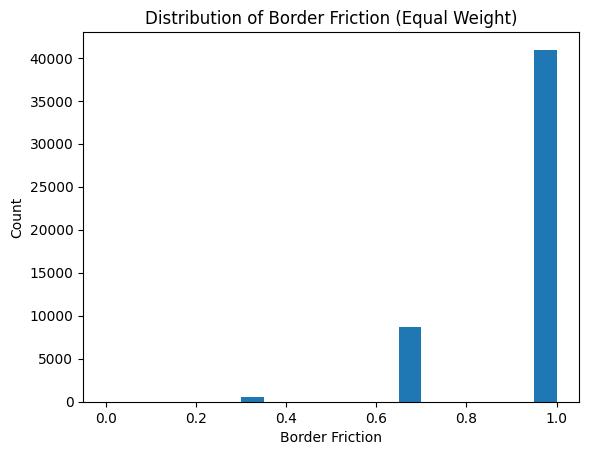

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取结果
df_border = pd.read_csv('../data/processed/border_friction_panel_ew.csv')

# 1. 基本统计
print(df_border['border_friction'].describe())
print("缺失值数量：", df_border['border_friction'].isnull().sum())

# 2. 查看极值
print("最小值对应的国家对：")
print(df_border[df_border['border_friction'] == df_border['border_friction'].min()])
print("最大值对应的国家对：")
print(df_border[df_border['border_friction'] == df_border['border_friction'].max()])

# 3. 分布直方图
plt.hist(df_border['border_friction'], bins=20)
plt.xlabel('Border Friction')
plt.ylabel('Count')
plt.title('Distribution of Border Friction (Equal Weight)')
plt.show()